<table>
    <tr>
        <td><img src="./imagenes/Macc.png" width="400"/></td>
        <td>&nbsp;</td>
        <td>
            <table><tr>
            <tp>
                <h1 style="color:blue;text-align:center">Aprendizaje por refuerzo</h1
            </tp>
            <tp>
                <p style="font-size:150%;text-align:center">Procesos de decisión de Markov y Programación dinámica</p></tp>
            </tr></table>
        </td>
    </tr>
</table>

---

# Objetivo <a class="anchor" id="inicio"></a>

En este notebook veremos una manera de implementar los ambientes de tarea de los MDP. Esta implementación sigue el formato de los entornos de [gym](https://gymnasium.farama.org). También implementaremos los algoritmos de Programación dinámica para la evaluación y mejoramiento de políticas.

Este notebook está basado en las presentación de Sanghi (2021), capítulo 2 y sus [notebooks](https://github.com/Apress/deep-reinforcement-learning-python); Sutton R., & Barto, A., (2015), capítulos 3 y 4; y también Winder, P., (2021), capítulo 2 y su [notebook](https://rl-book.com/learn/mdp/code_driven_intro/). 

[Ir a ejercicio 1](#ej1)

# Dependencias

Al iniciar el notebook o reiniciar el kerner, se pueden cargar todas las dependencias de este notebook al correr las siguientes celdas. Este también es el lugar para instalar las dependencias faltantes.

In [ ]:
#!pip install -r requirements.txt

**De Python:**

In [1]:
from IPython import display
from time import sleep
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from gymnasium.wrappers import TimeLimit
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

**Del notebook:**

In [2]:
from Tiempos import *
from ambientes import *
from agentes import Agent
from utils import Episode, PlotGridValues

%reload_ext autoreload
%autoreload 2

# Secciones

Desarrollaremos la explicación de la siguiente manera:

1. [Ejemplos de implementación](#impl).
    1. [ABC](#abc).
    2. [GridWorld](#gw).
    3. [Frozen Lake](#frozen).
2. [Evaluación de políticas](#poli-eval).
3. [Mejoramiento de políticas](#dp).
    1. [Policy iteration](#poli-iter).
    2. [Value iteration](#value-iter).
    3. [Resolviendo el Frozen Lake](#fl).
    3. [Comparación de tiempos](#comp).


---

# Ejemplos de implementación <a class="anchor" id="impl"></a>

([Volver al inicio](#inicio))

Existen muchísimas aplicaciones muy interesantes de RL. Ellas requieren ambientes relativamente complejos, incluso simulaciones del mundo físico en 3D. En este momento existen muchos ambientes ya implementados en python y de acceso libre, que han sido compilados en los [ambientes de gym](https://gymnasium.farama.org) de la empresa OpenAI. Vamos a familiarnos un poco con la implementación particular propuesta por esta librería.

Comenzaremos con la implementación de un ejemplo muy usado para visualizar valores de estados y políticas, que es el ejemplo del Grid World. Luego, mostraremos la implementación del problema del Frozen Lake, el cual es un ejemplo de un entorno tomado de Gym.

## ABC <a class="anchor" id="abc"></a>

([Volver a Ejemplos](#impl))

Un entorno muy sencillo que hemos trabajado en clase es el ABC:

<img src="./imagenes/abc.png" width="500"/>

In [ ]:
# Instantiate the environment
env = ABC()
print("Acciones posibles (valores):", env.action_space)
print("Acciones posibles (nombres):", np.vectorize(env.dict_acciones.get)(env.action_space))
print('')
print("Número de acciones posibles:", len(env.action_space))
print('')
a = random.choice(env.action_space)
print("Una acción posible seleccionada al azar:", env.dict_acciones[a])
print('')
print("El estado actual es:", env.state, "que corresponde a", env.dict_states[env.state])

Al imprimir el objeto podemos ver el modelo del MDP que ha sido implementado mediante el método `_transition_prob`, el cual define, para cada estado y acción, la siguiente tupla: 

(probabilidad, próximo estado, recompensa, finalizado)

In [ ]:
print(env)

---

## Grid World <a class="anchor" id="gw"></a>

([Volver a Ejemplos](#impl))

Un ejemplo muy útil en términos de visualización de MDP es el del Grid World, el cual consiste de una rejilla rectangular. Las casillas corresponden a los estados. Hay cuatro acciones: norte, sur, este y oeste, que hacen que el agente se mueva una casilla en la dirección respectiva en la rejilla. Las acciones que sacarían al agente de la rejilla dejan su ubicación sin cambios. Cada acción da como resultado una recompensa de -1. Las casillas (3,0) y (0,3) son estados terminales.

Veamos una implementación *ad hoc* tomada del libro de Sanghi (ver [código](https://github.com/Apress/deep-reinforcement-learning-python/blob/main/chapter3/gridworld.py)):

Observemos algunas características de la clase `GridworldEnv`:

In [ ]:
# Instantiate the environment
shape = (4,4)
env = GridworldEnv(shape=shape)
print("Acciones posibles (valores):", env.action_space)
print("Acciones posibles (nombres):", np.vectorize(env.dict_acciones.get)(env.action_space))
print('')
print("Número de acciones posibles:", len(env.action_space))
print('')
a = random.choice(env.action_space)
print("Una acción posible seleccionada al azar:", env.dict_acciones[a])
print('')
print("El estado actual es:", env.state, "que corresponde a la casilla", np.unravel_index(env.state, shape))

Al imprimir el objeto podemos ver el modelo del MDP que ha sido implementado mediante el método `_transition_prob`, el cual define, para cada estado y acción, la siguiente tupla: 

(probabilidad, próximo estado, recompensa, finalizado)

In [ ]:
print(env)

Uno de los métodos más importantes de la clase es el `step()`, el cual recibe una acción como argumento y, junto con la información del estado actual y el modelo de transiciones, obtiene el estado al que pasa el sistema y devuelve una recompensa. También se obtiene un valor booleano que indica si el estado obtenido es terminal o no:

In [ ]:
env = GridworldEnv()
env.render()
Y, X = np.unravel_index(env.state, env.shape)
print(f'Estado={env.state} at ({X}, {Y})')
obs, reward, done = env.step(env.EAST)
Y, X = np.unravel_index(env.state, env.shape)
print(f'Estado={obs} at at ({X}, {Y}), Recompensa={reward}, Finalizado={done}')
env.render()

<a class="anchor" id="ej1"></a>**Ejercicio 1:** 

([Próximo ejercicio](#ej2))

Cree una pequeña función para hacer una caminata aleatoria por la rejilla hasta que el agente llegue a un estado terminal. Encuentre la utlidad del episodio.

**Respuesta:**

Una implementación es la siguiente:

In [ ]:
env = GridworldEnv()
env.render()
done = False
utilidad = 0
while not done:
    a = random.choice(env.action_space)
    result = env.step(a)
    obs, reward, done = result[0], result[1], result[2]
    utilidad += reward
    display.clear_output(wait=True)
    env.render()
    sleep(.1) 
print("La utilidad del episodio fue:", utilidad)

---

## Frozen lake <a class="anchor" id="frozen"></a>

([Volver a Ejemplos](#impl))

Ahora veremos un entorno de gymnasium que se llama [fozen lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/). El agente debe cruzar un lago congelado de principio a fin sin caer en ningún agujero al caminar. Es posible que el jugador no siempre se mueva en la dirección deseada debido a la naturaleza resbaladiza del lago congelado.

El código fuente del entorno puede encontrarse en: [source code](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/toy_text/frozen_lake.py)



In [ ]:
is_slippery = True  # Make False to avoid slipping
env = gym.make('FrozenLake-v1', 
               desc=None, 
               map_name="4x4",
               is_slippery=is_slippery, 
               render_mode='rgb_array')
obs = env.reset()
print("Observacion inicial: ", obs)
print("Número de acciones posibles:", env.action_space.n)
print("Acciones posibles:", env.action_space)
print("Una acción posible seleccionada al azar:", env.action_space.sample())

Al igual que en el anterior ambiente, podemos acceder a las probabilidades de transición:

In [ ]:
env.P

Visualizamos algunas acciones aleatorias del agente en el entorno. Esta vez usamos la clase `Episode` del módulo `utils` y el agente `Agent` del módulo `agentes`:

In [ ]:
is_slippery = False
size = 4
max_rounds = 50
# Create environment
env = gym.make('FrozenLake-v1', 
               desc=None, 
               map_name="4x4",
               is_slippery=is_slippery, 
               render_mode='rgb_array'
              )
env = TimeLimit(env, max_episode_steps=max_rounds)
# Create agent
parameters = {
    "nS": size*size,
    "nA": env.action_space.n,
    "gamma":0.99,
    "epsilon":0
}
agent = Agent(parameters=parameters)
# Create episode
episodio = Episode(environment=env,\
        agent=agent,\
        model_name='Random',\
        num_rounds=15)
# Visualize
episodio.renderize()

---

# Evaluación de políticas <a class="anchor" id="poli-eval"></a>

([Volver al inicio](#inicio))

Vamos a usar la programación dinámica para encontrar los valores de estado para una política dada. La idea central es usar la ecuación de Bellman como una regla iterativa:

$$v_{k+1}(s) = \sum_{s'}\left( p(s' | s,\pi(s)) \Bigl[ r + \gamma v_k(s') \Bigr] \right)$$

Esto da lugar al siguiente algoritmo:

<img src="./imagenes/policy_evaluation.png" width="550"/>

<a class="anchor" id="ej2"></a>**Ejercicio 2:** 

([Anterior ejercicio](#ej1)) ([Próximo ejercicio](#ej3))

Vamos a encontrar los valores de estado para el problema del [ABC](#abc). Implemente el algoritmo iterativo de evaluación de políticas y utilícelo para encontrar los valores de la política `policy`, de acuerdo a la cual el agente se mueve a la derecha en cualquier estado:

In [ ]:
# Policy evaluation

def policy_eval(env, policy, discount_factor=1.0, theta=0.01, verbose=False):
    """
    Evalúa una política para un entorno.
    Input:
        - env: transition dynamics of the environment.
            env.P[s][a] [(prob, next_state, reward, done)].
            env.nS is number of states in the environment.
            env.nA is number of actions in the environment.
        - policy: vector de longitud env.nS que representa la política
        - discount_factor: Gamma discount factor.
        - theta: Stop iteration once value function change is
            less than theta for all states.
        - verbose: 0 no imprime nada, 
                   1 imprime la iteración del valor
    Output:
        Vector de longitud env.nS que representa la función de valor.
    """
    
    def expected_value(s, V):
        # Calcular el valor esperado as per backup diagram
        value = 0
        a = policy[s]
        for prob, next_state, reward, done in env.P[s][a]:
            # AQUÍ SU CÓDIGO
            value += ... # la fórmula de valor esperado
            # AQUÍ TERMINA SU CÓDIGO
        return value
    
    # Start with a (all 0) value function
    V = np.zeros(env.nS)
    # Stop if change is below a threshold
    continuar = True
    while continuar:
        delta = 0
        for s in range(env.nS):
            # AQUÍ SU CÓDIGO
            v = ... # el valor guardado para s
            V[s] = ... # el nuevo valor en términos del expected_value
            delta = ... # la diferencia del nuevo valor con el valor guardado
            # AQUÍ TERMINA SU CÓDIGO
            if verbose:
                print(f'V[{env.dict_states[s]}]={round(V[s], 3)}; ', end='')
        continuar = not delta < theta
        print('')
    return V


In [ ]:
env = ABC()
policy = [env.RIGHT, env.RIGHT, env.RIGHT]
V = policy_eval(
    env,
    policy, 
    discount_factor=0.8, 
    theta=1e-4, 
    verbose=True
)

**Nota:** El resultado de debe ser 
```
V[A]=-1.0; V[B]=8.9; V[C]=0.0; 
V[A]=5.328; V[B]=9.612; V[C]=0.0; 
V[A]=6.347; V[B]=9.669; V[C]=0.0; 
V[A]=6.469; V[B]=9.674; V[C]=0.0; 
V[A]=6.482; V[B]=9.674; V[C]=0.0; 
V[A]=6.484; V[B]=9.674; V[C]=0.0; 
```

**Respuesta:**

Una implementación es la siguiente:

In [3]:
# Policy evaluation

def policy_eval(env, policy, discount_factor=1.0, theta=0.01, verbose=False):
    """
    Evalúa una política para un entorno.
    Input:
        - env: transition dynamics of the environment.
            env.P[s][a] [(prob, next_state, reward, done)].
            env.nS is number of states in the environment.
            env.nA is number of actions in the environment.
        - policy: vector de longitud env.nS que representa la política
        - discount_factor: Gamma discount factor.
        - theta: Stop iteration once value function change is
            less than theta for all states.
        - verbose: 0 no imprime nada, 
                   1 imprime la iteración del valor
    Output:
        Vector de longitud env.nS que representa la función de valor.
    """
    
    def expected_value(s, V):
        # Calcular el valor esperado as per backup diagram
        value = 0
        a = policy[s]
        for prob, next_state, reward, done in env.P[s][a]:
            value += prob * (reward + discount_factor * V[next_state])
        return value
    
    # Start with a (all 0) value function
    V = np.zeros(env.nS)
    # Stop if change is below a threshold
    continuar = True
    while continuar:
        delta = 0
        for s in range(env.nS):
            v = V[s]
            V[s] = expected_value(s, V)
            delta = max(delta, np.absolute(v - V[s]))
            if verbose:
                print(f'V[{env.dict_states[s]}]={round(V[s], 3)}; ', end='')
        continuar = not delta < theta
        print('')
    return V

---

<a class="anchor" id="ej3"></a>**Ejercicio 3:** 

([Anterior ejercicio](#ej2)) ([Próximo ejercicio](#ej4))

Vamos a encontrar los valores de estado para el entorno del GridWorld. Usaremos la política `policy` definida en la siguiente celda:

In [ ]:
shape = (4,4)
env = GridworldEnv()
policy = [env.NORTH, env.EAST, env.EAST, env.SOUTH] * 4
pp = PlotGridValues(shape=shape, action_dict=env.dict_acciones)
pp.plot_policy(np.reshape(policy, shape))

In [ ]:
# Ejercicio 3
V = ... # aquí el código para correr policy_eval
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
pp.plot_policy(np.flipud(np.reshape(policy, shape)), ax=ax[0])
pp.plot_V_values(V=np.flipud(np.reshape(V, shape)), ax=ax[1])
ax[0].set_title('Policy', fontsize='18')
ax[1].set_title('Values', fontsize='18')
%matplotlib inline

**Respuesta:**

In [ ]:
# Ejercicio 3
V = policy_eval(env, 
                policy, 
                discount_factor=1, 
                theta=0.1, 
                verbose=False)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
pp.plot_policy(np.flipud(np.reshape(policy, shape)), ax=ax[0])
pp.plot_V_values(V=np.flipud(np.reshape(V, shape)), ax=ax[1])
ax[0].set_title('Policy', fontsize='18')
ax[1].set_title('Values', fontsize='18')
%matplotlib inline

---

# Mejoramiento de políticas <a class="anchor" id="dp"></a>

([Volver al inicio](#inicio))

Recordemos que el propósito del RL es encontrar la acción que mejor utilidad tenga en cada estado, determinando así la política óptima para el problema. Si conocemos el modelo de un MDP, podemos ir mejorando una política paso a paso. Los dos métodos de esta sección realizan el mejoramiento de una política hasta llegar a la política óptima. 

## Policy iteration <a class="anchor" id="poli-iter"></a>

([Volver a Mejoramiento](#dp))

En este algoritmo se busca mejorar una política $\pi$ en cada estado $s$, definiendo $\pi'$ de tal manera que:

$$\pi'(s) = \mbox{arg}\max_a q_{\pi}(s,a)$$

Esto da lugar a una nueva política $\pi'$. Luego, se recalculan los valores $v_{\pi'}(s)$ usando el algoritmo de evaluación de política visto en la sección anterior. Este proceso se itera hasta converger a la política óptima:

<img src="./imagenes/p_i.png" width="350"/>

El algoritmo es el siguiente:

<img src="./imagenes/policy_iteration1.png" width="550"/>

<a class="anchor" id="ej4"></a>**Ejercicio 4:** 

([Anterior ejercicio](#ej3)) ([Próximo ejercicio](#ej5))

Implemente el algoritmo de policy improvement y mejore la política del ejercicio 3.

In [ ]:
# Policy Improvement

def policy_iteration(env, pol, discount_factor=1.0, theta=0.01):      
    """
    Mejoramiento de una política.
    Input:
        - env: OpenAI env. env.P -> transition dynamics of the environment.
            env.P[s][a] [(prob, next_state, reward, done)].
            env.nS is number of states in the environment.
            env.nA is number of actions in the environment.
        - pol: vector de longitud env.nS que representa la política
        - discount_factor: Gamma discount factor.
        - theta: Stop iteration once value function change is
            less than theta for all states.
        - verbose: bool to print intermediate values. 
    Output:
        Vector de longitud env.nS que representa la política óptima.
    """     
    def expected_value(s, a, env, V):
        # Calcular el valor esperado as per backup diagram
        value = 0
        for prob, next_state, reward, done in env.P[s][a]:
            # Aquí su código
            value += ... # expected value
            # Hasta aquí su código
        return value

    V = np.zeros(env.nS)
    policy = deepcopy(pol)
    policy_stable = False
    while not policy_stable:
        # Aquí su código
        V = ... # policy evaluation
        policy_stable = True
        for s in range(env.nS):
            a = ... # action predicted by policy at state s
            policy[s] = ... # argmax of expected values
            if a != policy[s]:
                policy_stable = ... # Boolean to check if policy is the same
        # Hasta aquí su código
    return policy, V

In [ ]:
shape = (4,4)
env = GridworldEnv()
pp = PlotGridValues(shape=shape, action_dict=env.dict_acciones)
policy = ([env.NORTH] + [env.EAST]* (shape[0]-2) + [env.SOUTH]) * shape[1]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
pp.plot_policy(np.reshape(policy, shape), ax=ax[0])
policy, V = policy_iteration(env, policy, discount_factor=1, theta=0.01)
pp.plot_policy(np.reshape(policy, shape), V=V.reshape(shape), ax=ax[1])
ax[0].set_title('Initial policy', fontsize='18')
ax[1].set_title('Final policy', fontsize='18')
%matplotlib inline

**Nota:** La respuesta debe ser:

<img src="./imagenes/pol_it.png" width="400"/>

**Respuesta:**

Una implementación es la siguiente:

In [ ]:
# Policy Improvement

def policy_iteration(env, pol, discount_factor=1.0, theta=0.01):      
    """
    Mejoramiento de una política.
    Input:
        - env: OpenAI env. env.P -> transition dynamics of the environment.
            env.P[s][a] [(prob, next_state, reward, done)].
            env.nS is number of states in the environment.
            env.nA is number of actions in the environment.
        - pol: vector de longitud env.nS que representa la política
        - discount_factor: Gamma discount factor.
        - theta: Stop iteration once value function change is
            less than theta for all states.
        - verbose: bool to print intermediate values. 
    Output:
        Vector de longitud env.nS que representa la política óptima.
    """    
    def expected_value(s, a, env, V):
        # Calcular el valor esperado as per backup diagram
        value = 0
        for prob, next_state, reward, done in env.P[s][a]:
            value += prob * (reward + discount_factor * V[next_state])
        return value

    V = np.zeros(env.nS)
    policy = deepcopy(pol)
    policy_stable = False
    while not policy_stable:
        V = policy_eval(env, 
                        policy, 
                        discount_factor=discount_factor, 
                        theta=theta)
        policy_stable = True
        for s in range(env.nS):
            a = policy[s]
            policy[s] = np.argmax([expected_value(s, a, env, V) for a in range(env.nA)])
            if a != policy[s]:
                policy_stable = False
    return policy, V

---

Podemos visualizar el comportamiento del agente con esta política:

In [ ]:
# Create environment
shape = (4,4)
env = GridworldEnv(shape=shape)
# Create agent
parameters = {
    "nS": size*size,
    "nA": env.nA,
    "gamma":0.99,
    "epsilon":0
}
agent = Agent(parameters=parameters)
stochastic_policy = {(s, a):1 if policy[s]==a else 0 for a in range(env.nA) for s in range(env.nS)}
agent.policy = stochastic_policy
# Create episode
episodio = Episode(environment=env,\
        agent=agent,\
        model_name='DP',\
        num_rounds=15)
# Visualize
episodio.sleep_time = 0.5
episodio.renderize()

---

## Value iteration <a class="anchor" id="value-iter"></a>

([Volver a Mejoramiento](#dp))

Para mejorar el desempeño del algoritmo de policy iteration, se puede truncar la evaluación de la política después de una iteración para cada estado. Además, se puede combinar, en una sola regla iterativa, el mejoramiento de la política con la evaluación truncada de la política:

$$v_{k+1}(s) = \max_{a}\sum_{s'}\left( p(s' | s, a) \Bigl[ r + \gamma  v_{k}(s') \Bigr] \right)$$

Se puede demostrar que la sucesión $\{v_k\}$ converge a $v_*$. 

<img src="./imagenes/diagrama_value_iteration.png" width="250"/>

Finalmente, para obtener la política óptima $\pi_*$ se buscan las acciones mediante el argmax de los valores óptimos obtenidos en el proceso anterior:

$$\pi_*(s) = \mbox{arg}\max_a\sum_{s'}\left( p(s' | s, a) \Bigl[ r + \gamma  v_{*}(s') \Bigr] \right)$$

El algoritmo es el siguiente:

<img src="./imagenes/value_iteration.png" width="550"/>

<a class="anchor" id="ej5"></a>**Ejercicio 5:** 

([Anterior ejercicio](#ej4)) ([Próximo ejercicio](#ej6))

Implemente el algoritmo de value-iteration para encontrar la política óptima del MDP. Use su algoritmo para encontrar la política óptima del Grid World. El resultado debe ser la misma política óptima encontrada mediante el método `policy_iteration` en el ejercicio 4.

In [ ]:
# Ejercicio 5
# Value iteration
def value_iteration(env, discount_factor=1.0, theta=0.01):
    """
    Mejoramiento de una política.
    Input:
        - env: OpenAI env. env.P -> transition dynamics of the environment.
            env.P[s][a] [(prob, next_state, reward, done)].
            env.nS is number of states in the environment.
            env.nA is number of actions in the environment.
        - discount_factor: Gamma discount factor.
        - theta: Stop iteration once value function change is
            less than theta for all states.
    Output:
        Vector de longitud env.nS que representa la política óptima.
    """ 
    pass
    def expected_value(s, a, env, V):
        value = 0
        # Calcular el valor esperado as per backup diagram
        for prob, next_state, reward, done in env.P[s][a]:
            # Aquí su código
            value += ... # expected value
            # Hasta aquí su código
        return value
    
    V = np.zeros(env.nS)
    continuar = True
    while continuar:
        # Aquí su código
        delta = ... # initialize delta
        for s in range(env.nS):
            v = ... # previous stored value
            V[s] = ... # new value is max expected value
            delta = ... # max between previous and new value 
        continuar = not delta < theta
    # Update policy
    policy = [np.argmax([expected_value(s, a, env, V) for a in range(env.nA)]) for s in range(env.nS)]
    return policy, V

In [ ]:
shape = (4,4)
env = GridworldEnv()
policy, V = value_iteration(env, discount_factor=1, theta=0.01)
pp = PlotGridValues(shape=shape, action_dict=env.dict_acciones)
pp.plot_policy(np.reshape(policy, shape), V=np.reshape(V, shape))
%matplotlib inline

**Respuesta:**

Una implementación es la siguiente:

In [10]:
# Value iteration

def value_iteration(env, discount_factor=1.0, theta=0.01):
    """
    Mejoramiento de una política.
    Input:
        - env: OpenAI env. env.P -> transition dynamics of the environment.
            env.P[s][a] [(prob, next_state, reward, done)].
            env.nS is number of states in the environment.
            env.nA is number of actions in the environment.
        - discount_factor: Gamma discount factor.
        - theta: Stop iteration once value function change is
            less than theta for all states.
    Output:
        Vector de longitud env.nS que representa la política óptima.
    """ 
    def expected_value(s, a, env, V):
        value = 0
        # Calcular el valor esperado as per backup diagram
        for prob, next_state, reward, done in env.P[s][a]:
            value += prob * (reward + discount_factor * V[next_state])
        return value
    
    V = np.zeros(env.nS)
    continuar = True
    while continuar:
        delta = 0
        for s in range(env.nS):
            v = V[s]
            V[s] = np.max([expected_value(s, a, env, V) for a in range(env.nA)])
            delta = max(delta, np.absolute(v - V[s]))
        continuar = not delta < theta
    policy = [np.argmax([expected_value(s, a, env, V) for a in range(env.nA)]) for s in range(env.nS)]
    return policy, V

In [ ]:
env = ABC()
policy, V = value_iteration(env, discount_factor=1, theta=0.01)
print(policy)
V

In [ ]:
env = GridworldEnv()
policy, V = value_iteration(env, discount_factor=1, theta=0.01)
print(policy)
V

---

## Resolviendo el Frozen Lake  <a class="anchor" id="fl"></a>

([Volver a Mejoramiento](#dp))


Ya tenemos las herramientas para resolver el entorno del Frozen Lake. En este entorno, el agente debe caminar por el hielo para recoger el regalo que se encuentra al otro lado sin caerse en ninguno de los huecos en el hielo. El problema es que el hielo es resbaladizo y el agente puede resbalarse y moverse hacia alguno de los lados con probabilidad 1/3. Veámos cuál es la política óptima con un solo hueco en el hielo:

In [ ]:
# Create environment
is_slippery = True
size = 4
max_rounds = 50
shape = (4,4)
env = gym.make('FrozenLake-v1', 
               desc=["SFFF", "FFHF", "FFFF", "FFFG"], 
               is_slippery=is_slippery, 
               render_mode='rgb_array'
              )
env = TimeLimit(env, max_episode_steps=max_rounds)
env.reset()
dict_acciones = {3:"⬆", 2:"➡", 1:"⬇", 0:"⬅"}
dict_states = dict(zip([s for s in range(16)], [np.unravel_index(s, (4,4)) for s in range(16)]))
setattr(env, 'nS', 16)
setattr(env, 'nA', 4)
setattr(env, 'dict_acciones', dict_acciones)
setattr(env, 'dict_states', dict_states)
# Usamos value iteration para encontrar política óptima
policy, V = value_iteration(env,
                         discount_factor=0.9, 
                         theta=0.01)
pp = PlotGridValues(shape=shape, action_dict=env.dict_acciones)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[0].set_title('Environment', fontsize='18')
ax[0].axis("off")
ax[0].imshow(env.render())
pp.plot_policy(np.reshape(policy, shape), V=np.reshape(V, shape), ax=ax[1])
ax[1].set_title('Best policy', fontsize='18')
%matplotlib inline

Es importante observar que no hemos resuelto el problema mediante `policy_iteration`, sino mediante `value_iteration` debido a los tiempos de computación. Para ver detalles de la comparación entre los tiempos de los dos algoritmos, puede consultar la sección [Comparación de tiempos](#comp).

Veámos al agente en acción:

In [ ]:
is_slippery = True
size = 4
max_rounds = 50
# Create environment
env = gym.make('FrozenLake-v1', 
               desc=["SFFF", "FFHF", "FFFF", "FFFG"], 
#               map_name="4x4",
               is_slippery=is_slippery, 
               render_mode='rgb_array'
              )
env = TimeLimit(env, max_episode_steps=max_rounds)
dict_acciones = {3:"⬆", 2:"➡", 1:"⬇", 0:"⬅"}
dict_states = dict(zip([s for s in range(16)], [np.unravel_index(s, (4,4)) for s in range(16)]))
setattr(env, 'nS', 16)
setattr(env, 'nA', 4)
setattr(env, 'dict_acciones', dict_acciones)
setattr(env, 'dict_states', dict_states)
# Create agent
parameters = {
    "nS": size*size,
    "nA": env.nA,
    "gamma":0.9,
    "epsilon":0
}
agent = Agent(parameters=parameters)
stochastic_policy = {(s, a):1 if policy[s]==a else 0 for a in range(env.nA) for s in range(env.nS)}
agent.policy = stochastic_policy
# Create episode
episodio = Episode(environment=env,\
        agent=agent,\
        model_name='DP',\
        num_rounds=50)
# Visualize
episodio.sleep_time = 0.5
episodio.renderize()

---

## Comparación de tiempos <a class="anchor" id="comp"></a>

([Volver a Mejoramiento](#dp))

Vamos a hacer el estudio empírico de la complejidad de tiempos de los dos algoritmos. Correremos ambos algoritmos sobre el Grid World con tamaños (4,4) hasta (9,9). Con cada ambiente correremos 10 cada algoritmo y registraremos los tiempos de máquina usados para encontrar la política óptima. Los resultados son los siguientes: 

In [ ]:
p_i = lambda env: policy_iteration(env, get_nice_policy(env.shape))
v_i = lambda env: value_iteration(env)
funs = [p_i, v_i]
nombres_funs = ['policy-iteration', 'value-iteration']
shapes = [(n,n) for n in range(4,15)]
lista_args = [GridworldEnv(shape) for shape in shapes]
df = compara_entradas_funs(funs, nombres_funs, lista_args, N=10)
sns.lineplot(x='Long_entrada',y='Tiempo',hue='Funcion',data=df)
plt.savefig('figura.png', dpi=300)

La gráfica muestra el tiempo promedio que cada algoritmo toma para encontrar la política óptima con distintos tamaños del Grid World. A partir de la gráfica queda muy claro que el algoritmo de `value-iteration` es más eficiente que el de `policy-iteration`. Observe también que el primero no necesita una política de entrada, mientras que sí se requiere una política como argumento del `policy-iteration`. En este ejemplo se tomó una política que converge relativamente rápido, pero otras políticas toman muchísimo más tiempo en converger. Todo esto muestra las ventajas del `value-iteration`, el cual es más rápido y no requiere política de entrada.

Adicionalmente, observe que la complejidad de tiempo va creciendo mucho en ambos casos, lo cual hace que sean inviables para MDPs que tienen una gran cantidad de estados.

# En este notebook usted aprendió

* Cómo implementar MDP en python usando la librería `gym` de OpenAI.
* Cómo implementar la evaluación de una política, para obtener los valores en cada estado.
* Cómo implementar la metodología de mejoramiento de políticas mediante policy iteration y value iteration.

# Bibliografía

([Volver al inicio](#inicio))

Shanghi, N. (2021) Deep Reinforcement Learning with Python: With PyTorch, TensorFlow and OpenAI Gym. Apress. 

Sutton R., & Barto, A., (2015) Reinforcement Learning: An Introduction, 2nd Edition. A Bradford Book. Series: Adaptive Computation and Machine Learning series. 

Winder, P., (2021) Reinforcement Learning: Industrial Applications of Intelligent Agents. O’Relly.

# Puntos del examen final

In [4]:
# Create environment
is_slippery = True
size = 3
max_rounds = 50
shape = (3,3)
env = gym.make('FrozenLake-v1', 
               desc=["SFF", "FHF", "FFG"], 
               is_slippery=is_slippery, 
               render_mode='rgb_array'
              )
env = TimeLimit(env, max_episode_steps=max_rounds)
env.reset()
dict_acciones = {3:"⬆", 2:"➡", 1:"⬇", 0:"⬅"}
dict_states = dict(zip([s for s in range(9)], [np.unravel_index(s, (3,3)) for s in range(9)]))
setattr(env, 'nS', 9)
setattr(env, 'nA', 4)
setattr(env, 'dict_acciones', dict_acciones)
setattr(env, 'dict_states', dict_states)


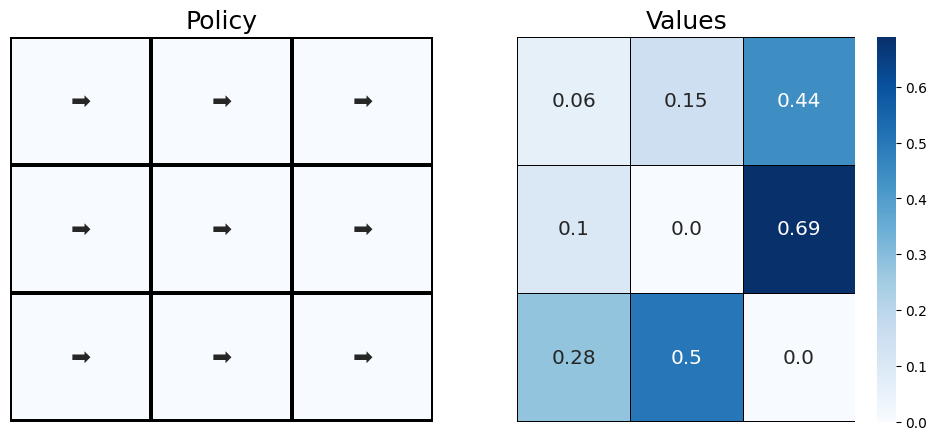

In [8]:
policy = [2, 2, 2] * 3
V = policy_eval(env, 
                policy, 
                discount_factor=1, 
                theta=0.1, 
                verbose=False)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
pp = PlotGridValues(shape=shape, dict_acciones=env.dict_acciones)
pp.plot_policy(policy, ax=ax[0])
pp.plot_V_values(V, ax=ax[1])
ax[0].set_title('Policy', fontsize='18')
ax[1].set_title('Values', fontsize='18')
%matplotlib inline

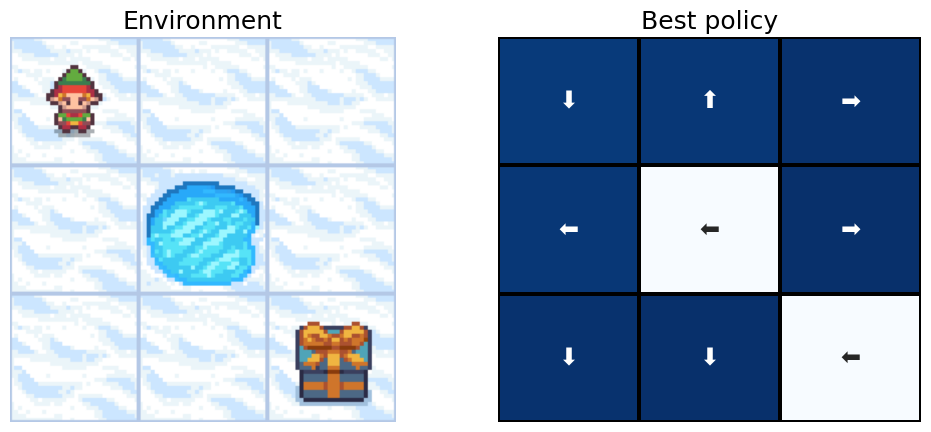

In [17]:
# Usamos value iteration para encontrar política óptima
policy, V = value_iteration(env,
                         discount_factor=1, 
                         theta=0.01)
pp = PlotGridValues(shape=shape, dict_acciones=env.dict_acciones)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[0].set_title('Environment', fontsize='18')
ax[0].axis("off")
ax[0].imshow(env.render())
pp.plot_policy(policy, V, ax=ax[1])
ax[1].set_title('Best policy', fontsize='18')
%matplotlib inline

In [ ]:
vv = np.array([round(x,2) for x in V]).reshape((3,3))
vv

In [ ]:
pp.plot_V_values(vv)